# Compare top interests
In which we compare the top interests according to some old audience counts to determine the right cutoff for an initial interest analysis of US versus Mexico.

TODO: repeat analysis with clean data

In [1]:
import pandas as pd
import json
from ast import literal_eval
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

## Load data

In [2]:
# collection was interrupted so we have to load the data in two parts
interest_data_old = pd.read_csv('../../data/query_results/US_MX_native_interests_top_3000_interest_old.csv', index_col=0)
interest_data_new = pd.read_csv('../../data/query_results/US_MX_native_interests_top_3000_interest_new_tmp.tsv', sep='\t', index_col=0)
all_interests = json.load(open('../../data/queries/US_MX_native_interests_top_3000_interest_new.json'))
all_interests = pd.DataFrame([{k : v[0] for k,v in i.iteritems()} for i in all_interests['interests']])
all_interests.rename(columns={'or' : 'id'}, inplace=True)
all_interests.loc[:, 'id'] = all_interests.loc[:, 'id'].astype(long)
# clean up
def clean_interest_data(data):
    data.fillna(0, inplace=True)
    print('original data has %d rows'%(data.shape[0]))
    data = data[data.loc[:, 'response'] != 0]
    print('clean data has %d rows'%(data.shape[0]))
    json_cols = ['interests', 'ages_ranges', 'behavior', 'geo_locations']
    for c in json_cols:
        data.loc[:, c] = data.loc[:, c].apply(literal_eval)
    ## if audience hasn't been computed, figure that out
    data.loc[:, 'response'] = data.loc[:, 'response'].apply(json.loads)
    audience_vars = ['dau_audience', 'mau_audience']
    for v in audience_vars:
        v_stem = v.split('_')[0]
        data.loc[:, v] = data.loc[:, 'response'].apply(lambda x: x['data'][0]['estimate_%s'%(v_stem)])
    # assume one interest/location per query
    data.loc[:, 'interest_id'] = data.loc[:, 'interests'].apply(lambda x: long(x['or'][0]))
    data.loc[:, 'interest_name']= data.loc[:, 'interests'].apply(lambda x: x['name'][0])
    data.loc[:, 'location'] = data.loc[:, 'geo_locations'].apply(lambda x: x['values'][0])
    final_cols = ['interest_id', 'interest_name', 'location', 'ages_ranges', 'behavior'] + audience_vars
    data = data.loc[:, final_cols]
    return data
interest_data_combined = pd.concat([interest_data_old, interest_data_new], axis=0)
interest_data_combined = clean_interest_data(interest_data_combined)
interest_data_combined.head()

original data has 10834 rows
clean data has 6033 rows


C:\Users\stewart\AppData\Local\Continuum\miniconda3\envs\assimilation_py27\lib\site-packages\pandas\core\indexing.py:476: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\stewart\AppData\Local\Continuum\miniconda3\envs\assimilation_py27\lib\site-packages\pandas\core\indexing.py:296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


,interest_id,interest_name,location,ages_ranges,behavior,dau_audience,mau_audience
0,6003142505790,Facebook,US,"{u'max': 65, u'min': 18}","{u'not': [6015559470583, 6025978286383], u'nam...",68950999,95000000
1,6003142505790,Facebook,MX,"{u'max': 65, u'min': 18}","{u'not': [6015559470583, 6025978286383], u'nam...",25690599,41000000
2,6003985771306,Technology,US,"{u'max': 65, u'min': 18}","{u'not': [6015559470583, 6025978286383], u'nam...",85469999,111000000
3,6003985771306,Technology,MX,"{u'max': 65, u'min': 18}","{u'not': [6015559470583, 6025978286383], u'nam...",27557599,38000000
4,6003349442621,Entertainment,US,"{u'max': 65, u'min': 18}","{u'not': [6015559470583, 6025978286383], u'nam...",89765399,123000000


Some of these numbers seem abnormally low, e.g. `dau_audience=769` for US `Business and Industry`. 

What does the overall distribution look like?

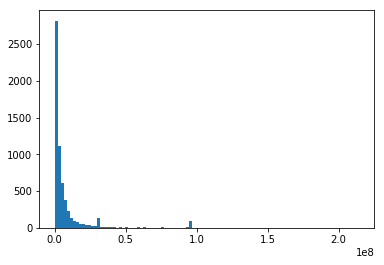

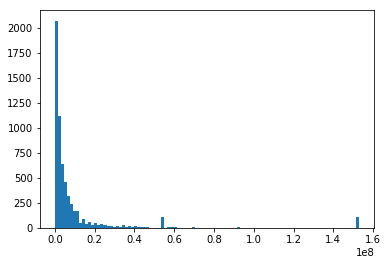

In [3]:
plt.hist(interest_data_combined.loc[:, 'dau_audience'], bins=100)
plt.show()
plt.hist(interest_data_combined.loc[:, 'mau_audience'], bins=100)
plt.show()

Most interests have a low count. Understandable! How about the log transformation?

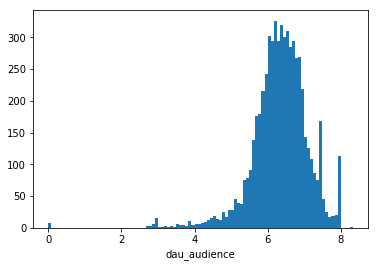

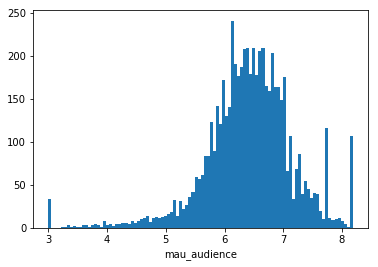

In [4]:
audience_vars = ['dau_audience', 'mau_audience']
for v in audience_vars:
    v_smooth = 1
    v_log = interest_data_combined.loc[:, v].apply(lambda x: pd.np.log10(x + v_smooth))
    plt.hist(v_log, bins=100)
    plt.xlabel(v)
    plt.show()

That's more reasonable. Most interests tend to have a daily audience size around 1,000,000 and monthly audience size around 3,000,000.

## Get top-k interests per country

In [5]:
countries = interest_data_combined.loc[:, 'location'].unique()
top_k = 100
for c, c_data in interest_data_combined.groupby('location'):
    for v in audience_vars:
        print('location=%s, audience=%s'%(c, v))
        c_data.sort_values(v, inplace=True, ascending=False)
        c_data.index = pd.np.arange(len(c_data))
        print(c_data.loc[:, ['interest_name', 'interest_id', v]].head(n=top_k))

location=MX, audience=dau_audience
                           interest_name       interest_id  dau_audience
0                               Hospital     6002964346117      45674787
1                                B O D Y     6008437398448      31250999
2                   Romantic comedy film     6003250002933      31250999
3                          nametests.com  1626452477572710      31250999
4                   Science fiction film     6003263279393      31250999
5                      Fatigue (medical)     6003705887546      31250999
6                                Dieting     6003327856180      31250999
7                                  Islam     6003301655169      31250999
8                                   EveR     6007635637752      31250999
9   Lewis and Clark-class dry cargo ship     6002964065372      31250999
10                          A.N.S.W.E.R.     6003207154776      31250999
11                                 Islam     6002949965174      30975999
12              

                           interest_name       interest_id  dau_audience
0                                  Adult     6003342807051     214388568
1                   Romantic comedy film     6003250002933      96655199
2                                B O D Y     6008437398448      96655199
3                      Fatigue (medical)     6003705887546      95318999
4                          nametests.com  1626452477572710      95318999
5                           A.N.S.W.E.R.     6003207154776      95318999
6                                  Islam     6003301655169      95318999
7                                   EveR     6007635637752      95318999
8                                Dieting     6003327856180      95318999
9   Lewis and Clark-class dry cargo ship     6002964065372      95318999
10                  Science fiction film     6003263279393      95318999
11                             Realidade     6016388157921      95135399
12                             Addiction     600332

__main__:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


This is weird. What happens if we ignore the top k% and focus on the lower tail?

In [6]:
pct = 97
top_k = 100
for c, c_data in interest_data_combined.groupby('location'):
    for v in audience_vars:
        # log-transform
        c_data.loc[:, v] = pd.np.log10(c_data.loc[:, v] + 1)
        print('location=%s, audience=%s'%(c, v))
        c_data.sort_values(v, inplace=True, ascending=False)
        c_data.index = pd.np.arange(len(c_data))
        # cut off upper percentile
        v_cutoff = pd.np.percentile(c_data.loc[:, v], pct)
        c_data = c_data[c_data.loc[:, v] < v_cutoff]
        print(c_data.loc[:, ['interest_name', 'interest_id', v]].head(n=top_k))

location=MX, audience=dau_audience
                interest_name    interest_id  dau_audience
108             Entertainment  6003349442621      7.461847
109                    Mexico  6002956937323      7.454387
110    Hobbies and activities  6012547807252      7.448809
111                Technology  6003985771306      7.440241
112     Business and industry  6008740787350      7.434697
113            Food and drink  6009248606271      7.421920
114      Shopping and fashion  6003167425934      7.421657
115                    Sports  6003269553527      7.421535
116       Entre Rios Province  6003117496988      7.421209
117                     Music  6003020834693      7.421051
118  Family and relationships  6012684376438      7.418743
119                  Facebook  6003142505790      7.409774
120            Social network  6003342621987      7.408803
121                      Food  6003266061909      7.408511
122      Consumer electronics  6003716669862      7.396576
123                  

__main__:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


                   interest_name       interest_id  dau_audience
94                         Zumba     6003369521274      7.976335
95                         Islam     6002949965174      7.975539
96                     Nutrition     6003324917336      7.975539
97                          Gyms     6003355530237      7.975539
98                   Hairdresser     6003619634928      7.975539
99            Online and offline     6003224184061      7.973849
100                 Christianity     6003207207886      7.973849
101                          Car  1518735155058940      7.973849
102           SWFL Mobile Fusion     6003130537617      7.973849
103                  Comedy film     6003169161534      7.973849
104         Elasticity (physics)     6003719449516      7.971443
105  Warrant Officer of the Navy     6003770178104      7.971443
106                  Foot (unit)     6003427635077      7.971443
107                          Bit     6003316614191      7.971443
108                Entert

This looks good enough for a first shot. Let's save to file with the monthly audience counts.

In [12]:
locations = ['US', 'MX']
audience_var = 'mau_audience'
top_k = 500
for l in locations:
    l_data = interest_data_combined[interest_data_combined.loc[:, 'location'] == l]
    pct = 97
    # log-transform
    log_audience_var = 'log_%s'%(audience_var)
    l_data.loc[:, log_audience_var] = pd.np.log10(l_data.loc[:, audience_var] + 1)
    print('location=%s, audience=%s'%(l, audience_var))
    l_data.sort_values(log_audience_var, inplace=True, ascending=False)
    l_data.index = pd.np.arange(len(l_data))
    # cut off upper percentile
    v_cutoff = pd.np.percentile(l_data.loc[:, log_audience_var], pct)
    l_data_k = l_data[l_data.loc[:, log_audience_var] < v_cutoff].head(n=top_k)
    l_file = '../../data/query_results/%s_top_%d_%s.csv'%(l, top_k, audience_var)
    l_data_k.loc[:, ['interest_name', audience_var]].to_csv(l_file, sep=',', index=False, encoding='utf-8')

location=US, audience=mau_audience
location=MX, audience=mau_audience


__main__:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Compare Ex-pat interests
We've now mined the top 3000 interests for Hispanic Mexican ex-pats living in the US, so let's see how those stack up against native US Americans.

In [121]:
import pandas as pd
from ast import literal_eval
expat_interests = pd.read_csv('../../dataframe_collecting_1527418768.csv', sep=',', index_col=0)
expat_interests = clean_interest_data(expat_interests)
print('%d results total'%(expat_interests.shape[0]))
expat_interests.head()

original data has 3000 rows
clean data has 2100 rows
2100 results total


,interest_id,interest_name,location,ages_ranges,behavior,dau_audience,mau_audience
0,6003349442621,Entertainment,US,"{u'max': 65, u'min': 18}","{u'and': [6023676072183], u'or': [600313321237...",26193599,34000000
1,6003142505790,Facebook,US,"{u'max': 65, u'min': 18}","{u'and': [6023676072183], u'or': [600313321237...",22969411,30000000
2,6003342621987,Social network,US,"{u'max': 65, u'min': 18}","{u'and': [6023676072183], u'or': [600313321237...",22028399,29000000
3,6003167425934,Shopping and fashion,US,"{u'max': 65, u'min': 18}","{u'and': [6023676072183], u'or': [600313321237...",25855999,32000000
4,6003985771306,Technology,US,"{u'max': 65, u'min': 18}","{u'and': [6023676072183], u'or': [600313321237...",25855999,32000000


In [122]:
audience_var = 'mau_audience'
expat_interests.sort_values(audience_var, inplace=True, ascending=False)
expat_interests.loc[:, ['interest_name', audience_var]].head(n=100)

,interest_name,mau_audience
524,New Tang Dynasty Television,38000000
468,A.N.S.W.E.R.,38000000
705,Canadian Albums Chart,38000000
1740,Province,38000000
1756,Act-i-vate,38000000
1833,Indian people,38000000
1845,Message,38000000
1866,Suicide awareness,38000000
562,Allah,38000000
558,Dieting,38000000


In [123]:
expat_interests.loc[:, ['interest_name', audience_var]].tail(n=100)

,interest_name,mau_audience
2013,Tamil cinema,270000
972,Hacker (computer security),250000
1585,Export,250000
1640,Call centre,250000
1737,China Central Television,240000
2083,Departments of France,240000
1289,Man (Middle-earth),240000
2092,Storey,230000
1351,Bangkok,230000
1731,Zara (retailer),220000


Looks like we'll need to filter out the max_pop and min_pop values.

In [124]:
pd.set_option('display.max_rows', 100)
max_expat_audience = expat_interests.loc[:, audience_var].max()
min_expat_audience = expat_interests.loc[:, audience_var].min()
expat_interests_clean = expat_interests[(expat_interests.loc[:, audience_var] < max_expat_audience) &
                                        (expat_interests.loc[:, audience_var] > min_expat_audience)]
expat_interests_clean.loc[:, ['interest_name', audience_var]].head(n=100)

,interest_name,mau_audience
0,Entertainment,34000000
5,Hobbies and activities,33000000
10,Business and industry,32000000
3,Shopping and fashion,32000000
4,Technology,32000000
16,Music,31000000
8,Sports and outdoors,30000000
15,Food and drink,30000000
1,Facebook,30000000
9,Sports,30000000


These all look pretty reasonable! Who doesn't like `Coupons`?

Let's match the distribution with the American native interests, normalize for population size and then compare the distributions (overlapping histogram?? yes).

In [77]:
US_MX_interests = pd.read_csv('../../data/query_results/US_MX_native_interests_top_3000_interest_new_tmp.tsv', sep='\t', index_col=False)
US_MX_interests = clean_interest_data(US_MX_interests)
US_interests = US_MX_interests[US_MX_interests.loc[:, 'location'] == 'US']
MX_interests = US_MX_interests[US_MX_interests.loc[:, 'location'] == 'MX']

original data has 4834 rows
clean data has 4834 rows


In [78]:
# get rid of max values
max_US_audience = US_interests.loc[:, audience_var].max()
max_MX_audience = MX_interests.loc[:, audience_var].max()
min_US_audience = US_interests.loc[:, audience_var].min()
min_MX_audience = MX_interests.loc[:, audience_var].min()
US_interests = US_interests[(US_interests.loc[:, audience_var] < max_US_audience) &
                            (US_interests.loc[:, audience_var] > min_US_audience)]
MX_interests = MX_interests[(MX_interests.loc[:, audience_var] < max_MX_audience) &
                            (MX_interests.loc[:, audience_var] > min_MX_audience)]

In [66]:
US_interests.sort_values(audience_var, inplace=True, ascending=False)
US_interests.loc[:, ['interest_name', audience_var]].head(n=100)

,interest_name,mau_audience
2,Sports and outdoors,103000000
12,Automobiles,77000000
16,Politics and social issues,70000000
14,Live events,68000000
20,Home and garden,57000000
24,Li Ke,48000000
28,Homo sapiens,45000000
26,Imagem,41000000
1368,Walmart,39000000
58,Pinterest,37000000


In [67]:
US_interests.loc[:, ['interest_name', audience_var]].tail(n=100)

,interest_name,mau_audience
2798,African Union,120000
3682,Space age pop,120000
4248,Worldbeat,110000
2070,Franco De Vita,110000
4788,Public sector,110000
1444,Samsung Galaxy S III,110000
3586,Handball,110000
3724,International News Service v. Associated Press,110000
1798,Heel (shoe),110000
3600,Ronaldinho,100000


No more `Coupons`. Let's see how different these distributions are.

In [125]:
interest_vars = ['interest_name', audience_var]
expat_interest_normed = expat_interests_clean.loc[:, interest_vars]
US_interest_normed = US_interests.loc[:, interest_vars]
MX_interest_normed = MX_interests.loc[:, interest_vars]
expat_interest_normed.loc[:, audience_var] = expat_interest_normed.loc[:, audience_var] / max_expat_audience
US_interest_normed.loc[:, audience_var] = US_interest_normed.loc[:, audience_var] / max_US_audience
MX_interest_normed.loc[:, audience_var] = MX_interest_normed.loc[:, audience_var] / max_MX_audience

In [126]:
shared_interests = list(set(expat_interest_normed.loc[:, 'interest_name'].unique()) & set(US_interest_normed.loc[:, 'interest_name'].unique()))
print('%d shared interests'%(len(shared_interests)))

1447 shared interests


In [127]:
combined_interests = pd.merge(expat_interest_normed.rename(columns={audience_var:'%s_expat'%(audience_var)}), 
                              US_interest_normed.rename(columns={audience_var:'%s_US'%(audience_var)}), on='interest_name')
combined_interests = pd.merge(combined_interests, 
                              MX_interest_normed.rename(columns={audience_var:'%s_MX'%(audience_var)}), on='interest_name')
combined_interests.sort_values('interest_name', inplace=True, ascending=True)
combined_interests.head()

,interest_name,mau_audience_expat,mau_audience_US,mau_audience_MX
1090,"1,000,000,000",0.024211,0.028105,0.006000
1234,1080p,0.017105,0.010458,0.011273
1340,20th Century Fox,0.010000,0.005686,0.076364
461,3D computer graphics,0.057895,0.037255,0.021818
1390,4G,0.004737,0.003791,0.004909


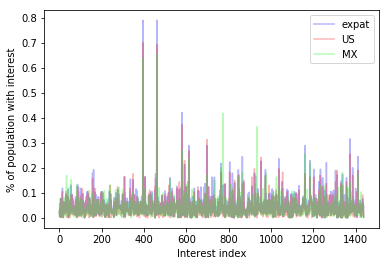

In [139]:
ax = plt.subplot(111)
x = pd.np.arange(combined_interests.shape[0])
ax.plot(x, combined_interests.loc[:, '%s_expat'%(audience_var)], label='expat', color=[0.05,0.05,0.95,0.3])
ax.plot(x, combined_interests.loc[:, '%s_US'%(audience_var)], label='US', color=[0.95,0.05,0.05,0.3])
ax.plot(x, combined_interests.loc[:, '%s_MX'%(audience_var)], label='MX', color=[0.05,0.95,0.05,0.3])
ax.set_xlabel('Interest index')
ax.set_ylabel('% of population with interest')
ax.legend(loc='upper right')
plt.show()

Looks like pretty close overlap on the whole, although the expat counts seem spikier (consistently higher than the other categories on maxima).

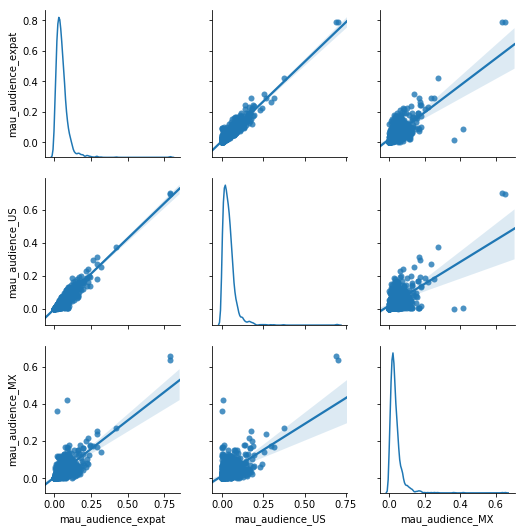

In [140]:
import seaborn as sns
matplotlib.rcParams['lines.markeredgewidth'] = 0
pal = sns.color_palette('Blues')
g = sns.pairplot(combined_interests.iloc[:, 1:], 
                 markers='o', palette=pal, 
                 diag_kind='kde', kind='reg')
plt.show()

Rough confirmation that the Ex-pats behave more like US than like MX.

In [141]:
from scipy.stats import pearsonr
countries = ['US', 'MX']
for c in countries:
    corr, pval = pearsonr(combined_interests.loc[:, '%s_%s'%(audience_var, c)],
                          combined_interests.loc[:, '%s_expat'%(audience_var)])
    print('%s R=%.3E (p=%.3E)'%(c, corr, pval))

US R=9.437E-01 (p=0.000E+00)
MX R=7.355E-01 (p=3.327E-245)


Now that we have established a correlation among expat interests and US interests, we should actually define the assimilation metric and compute that.

In [ ]:
# stolen from display_results.py (https://drive.google.com/file/d/1QzX4Re77H7PJrXk84qGHOB5RZ7FKjVzn)

def global_score(target_file, dest_file, home_file, score_type_, nb_int):
    """
    This function computes the assimilation score for a given target populations coming from some home population and
    trying to assimilate to a certain dest population
    :param target_file: File containing interests audiences for the target population
    :param dest_file: File containing interests audiences for the dest population
    :param home_file: File containing interests audiences for the home population
    :param score_type_: String indicating if the score should be computed using subtraction or division
    :param nb_int: Number of interests to consider
    :return: scores: the per-interest assimilation scores for each most german interests
             nb_target: the size of the target population
    """
    target_data = pd.read_csv(target_file, index_col=0)
    dest_data = pd.read_csv(dest_file, index_col=0)
    home_data = pd.read_csv(home_file, index_col=0)

    # Remove hand-picked interests
    target_audience = target_data['audience'][0:3000]
    dest_audience = dest_data['audience'][0:3000]
    home_audience = home_data['audience'][0:3000]

    nb_target = target_audience[0]
    nb_dest = dest_audience[0]
    nb_home = home_audience[0]

    # Remove erroneous audiences
    target_errors = (target_audience != nb_target)
    dest_errors = (dest_audience != nb_dest)
    home_errors = (home_audience != nb_home)
    errors = target_errors | dest_errors | home_errors
    target_audience = target_audience[errors]
    dest_audience = dest_audience[errors]
    home_audience = home_audience[errors]

    # Select a certain number of interests
    random.seed(0)
    int_ind = random.sample(list(dest_audience.index), nb_int)
    int_ind = np.sort(int_ind)

    target_audience = target_audience[int_ind]
    dest_audience = dest_audience[int_ind]
    home_audience = home_audience[int_ind]

    # Compute activity level
    target_nb_interests = target_audience.shape[0]
    total_nb_interested_target = target_audience.sum(0)
    dest_nb_interests = dest_audience.shape[0]
    total_nb_interested_dest = dest_audience.sum(0)
    home_nb_interests = home_audience.shape[0]
    total_nb_interested_home = home_audience.sum(0)

    # Compute interest ratios
    target_ir = target_audience.values / float(total_nb_interested_target)
    dest_ir = dest_audience.values / float(total_nb_interested_dest)
    home_ir = home_audience.values / float(total_nb_interested_home)

    # Keep only 'dest' interests
    dest_indexes = dest_ir > home_ir
    g_dest_ir = dest_ir[dest_indexes]
    g_home_ir = home_ir[dest_indexes]
    g_target_ir = target_ir[dest_indexes]

    # Keep only 'very dest' interests
    if score_type_ == '-':
        dest_home_perc = np.percentile(g_dest_ir - g_home_ir, TOP_PERC)
        very_dest_indexes = (g_dest_ir - g_home_ir) > dest_home_perc
    else:
        dest_home_perc = np.percentile(g_dest_ir / g_home_ir, TOP_PERC)
        very_dest_indexes = ((g_dest_ir / g_home_ir) > dest_home_perc)

    vg_dest_ir = g_dest_ir[very_dest_indexes]
    vg_target_ir = g_target_ir[very_dest_indexes]

    # Compute scores
    if score_type_ == '-':
        scores = vg_target_ir - vg_dest_ir
    else:
        scores = vg_target_ir / vg_dest_ir

    return scores, nb_target

In [ ]:
def interest_ratio():
    pass